# Pairs Trading with BTC and ETH, Using the t Copula
This notebook shows one how can one can model the codependency structure between two assets, using a copula, for the purpose of creating a pairs trading strategy. The first section of this notebook will very briefly explain what a copula is and why we might want to use it for this kind of trading strategy. Copulas can get fairly complicated, fairly quickly and I am by no means an expert on the subject matter. For that reason, I will keep the theoretical part as high-level as possible, trying to build an intuitive understanding of copulas, versus trying to build a mathematically rigorous one. I will link to a easy-to-digest six page PDF on Copulas at the end of the theory section and will also list additional references I have used at the very end. After all the theory is out of the way, we dive into the code! The data used for this project is BTC and ETH prices sampled at 6-hour intervals. 

### What is a copula?
A copula is essentially a kind of joint probability distribution (PDF) that is used to model the dependence between two random variables. When describing the dependency between two random variables, we often use the correlation coefficient as singular numeric summary of this dependence but it has one significant drawback: The correlation coefficient only measures linear relationships whereas copulas are not restricted by non-linearity in the same way. 

If $ X_1 $ and $ X_2 $ are two random variables that are *not* independent, then, everything we might want to know about these two random variables is contained in the joint PDF. The joint PDF not only contains the marginal distributions of $ X_1 $ and $ X_2 $ but also the codependency structure between them. That means that, when trying to model two random variables with a joint PDF, we are actually modeling their marginal distributions and their codependence simultaneously. However, it turns out that one can "decompose" a joint PDF into the respective marginal distributions and a copula, which "links" the marginal distributions to their joint PDF counterpart. More specifically, in the bivariate case, the following equality holds: 

$$
F(x_1, x_2) = C(F_1(x_1), F_2(x_2))
$$

where $ F $ is some joint CDF, $ F_1 $ and $ F_2 $ are absolutely continuous marginal distributions and $ C $ is some copula. This relationship is *Sklar's Theorem* and is at the heart of anything copula-related. It can be written as

$$
C(u_1, u_2) = F(F_1^{-1}(x_1), F_2^{-1}(x_2))
$$

which highlights the opening point: The copula $ C $ is a joint probability distribution on the "points" we get when we feed a a random variable into its own CDF. The bottom line is this: Instead of modeling the distribution of $ X_1 $ and $ X_2 $ and the nature of their dependence simultaneously with a joint PDF, we can decompose the problem into modeling their marginal distributions and their copula separately. Since everything about $ X_1 $ is contained in its marginal distribution and everything about $ X_2 $ is contained in its marginal distribution, the copula *only* contains information about the structure of their codependency! Since we are doing pairs trading, we do not really care about BTC or ETH in isolation, we only care about their relationship so that we can bet on reversions whenever one of the two assets deviate from their relationship. First we need to describe this relationship, and that is exactly what the copula does. In particular, we can extract conditional probabilities from the copula, in similar fashion as to how we can extract conditional probabilities from a joint PDF. We could, in theory, answer a question like "*what is the probability that the price of BTC will drop, conditional on the current value of ETH?*",
however, since prices are not stationary, we have to settle with modeling log returns instead.

The choice of copula for this project is arbitrary. There are many copulas to choose from and one can even produce a "mixed" copula by using two or more "base" copulas. I am going to use the t copula which is derived from the multivariate t distribution. This copula is parameterized entirely by its correlation matrix and its degrees of freedom, the latter of which we are going to estimate via optimization. I will be using the univariate and multivariate t distribution for this project. mean and variance in the univariate case will always be 0 and 1 respectively and in the multivariate case, the mean vector will be a vector of zeros and the dispersion matrix $\Sigma$ will be the correlation matrix $P$. The reason for this, in short, is because of something called in the *invariance principle* of copulas. The details of this principle are not important for this presentation.

If you wish to get a better understanding of copulas and their application, I can highly recommend very short document titled *A Short, Comprehensive and Practical Guide to Copulas* (you can find a pdf [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi38ouL7_3uAhVko4sKHXmjCVkQFjAAegQIAhAD&url=http%3A%2F%2Fwww.finanzaonline.com%2Fforum%2Fattachments%2Feconometria-e-modelli-di-trading-operativo%2F1728366d1364911722-copula-per-principianti-quant_classroom_oct2011.pdf&usg=AOvVaw38rqNmG5_-tUhx0bEp0340) ) by Attilio Meucci. Further references are at the end of the notebook. 

### Okay, so how are we going to do this?
For the remainder of this presentation, let anything with subscript $ 1 $ be BTC log return (or the transformed log return, see below), and let anything with subscript $ 2 $ be ETH log return (or transformed log return).

#### Step 1
The *probability integral transform* states that, if $ Z = F_Y(Y) $, where $ F_Y  $ is the CDF of $ Y $, then $ Z \sim U(0,1) $ where $ U $ denotes the uniform distribution over $ [0,1] $. We compute 

$$
U_i = F_i(X_1)   \;\;\;\;  i =1,2
$$

by feeding the log returns into their respective empirical (marginal) CDFs. This produces something called *pseudo observations* from the copula. Note, if we first fit $X_1$ and $X_2$ to two parametric distributions with e.g. Maximum Likelihood Estimation and fed the returns through the corresponding CDFs, we would have "real" observations from our copula. But for this project, I am using the empirical CDF instead. 

#### Step 2
Fit a copula to the transformed log returns via Maximum Pseudo Likelihood estimation. This works exactly like normal Maximum Likelihood estimation, the difference in name is to indicate we are using pseudo observations. The density of the t copula with $\nu$ degrees of freedom and correlation matrix $P$ is given by 

$$
c_{\nu, P}^t = \frac{f_{\nu, P}(t_{\nu}^{-1}(u_1), t_{\nu}^{-1}(u_2))}{\prod_{i=1}^2f_{\nu}(t_{\nu}^{-1}(u_i))}
$$
where $f_{\nu, P}$ is the joint density of a $t_2(\nu, \textbf{0}, P)$ distributed random vector. with $\nu$ degrees of freedom and correlation matrix $P$ and $f_{\nu}$ is the density of the univariate t distribution. We "fit" the copula to our data by finding the parameter $\nu$ that maximizes the cumulative product of densities for every pair of $(u_1,u_2)$ or equivalently, the parameter $\mu$ that maximizes the sum of log likelihoods.   

#### Step 3
Compute conditional probabilities. For the t copula, this is done as follows:

$$
P(U_1 \leq u_1 |U_2 = u_2) = t_{\nu+1}\left(\frac{x_1-\rho x_2}{\sqrt{\frac{(\nu+x_2^2)(1-\rho^2)}{(\nu +1)}}}\right) \\
x_i = t_{\nu}^{-1}(u_i) \; \; \; i =1,2
$$

where $\nu$ denotes the degrees of freedom, $\rho$ is the correlation coefficient between $U_1$ and $U_2$,  $\; t_{\nu+1}$ is the t distribution function (CDF) with $\nu +1$ degrees of freedom, and $t_{\nu}^{-1}$ is the inverse of the t distribution function (aka. The t quantile function). The conditional distribution is derived as in the normal joint CDF case, namely by taking the partial derivative of the joint distribution function.

#### Step 4

Place trades based on the conditional probabilities. There are several ways one can design a trading strategy around these probabilities, but for this project, I will keep it simple. If the conditional probability is larger than 0.90, we short BTC and go long in ETH. We do the opposite when the conditional probability is less than 0.1. A long BTC / short ETH position is only closed when it is time to short BTC and go long ETH. We do this to maximize our time in the market, instead of putting too much emphasis on timing the market. This means that, if the conditional probability is 0.91 at time $t$ we go long BTC and short ETH and if the conditional probability is 0.11 at time $t+1$, we remain long BTC and short ETH. Alternatively one can unwind the long/short positions when the conditional probability falls within some range $[0.5 - \epsilon, 0.5 + \epsilon]$ such that there are periods of time where we do not have any positions.  

## Step 1

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from math import *
from scipy.stats import rankdata
from scipy.stats import t
from scipy.optimize import minimize 
plt.style.use('seaborn')

data = pd.read_csv('prices.csv', index_col='date')
data.index = pd.to_datetime(data.index)
df = data[0:round(len(data)/2)].copy()
out_of_sample_data = data[round(len(data)/2):].copy() 

df['btc_return'] = np.log(df['btcusd']) - np.log(df['btcusd'].shift(1))
df['eth_return'] = np.log(df['ethusd']) - np.log(df['ethusd'].shift(1))
df.dropna(inplace=True)
daily_returns = df[['btc_return', 'eth_return']]

out_of_sample_data['btc_return'] = np.log(out_of_sample_data['btcusd']) - np.log(out_of_sample_data['btcusd'].shift(1))
out_of_sample_data['eth_return'] = np.log(out_of_sample_data['ethusd']) - np.log(out_of_sample_data['ethusd'].shift(1))
out_of_sample_data.dropna(inplace=True)
out_of_sample_data = out_of_sample_data[['btc_return', 'eth_return']]


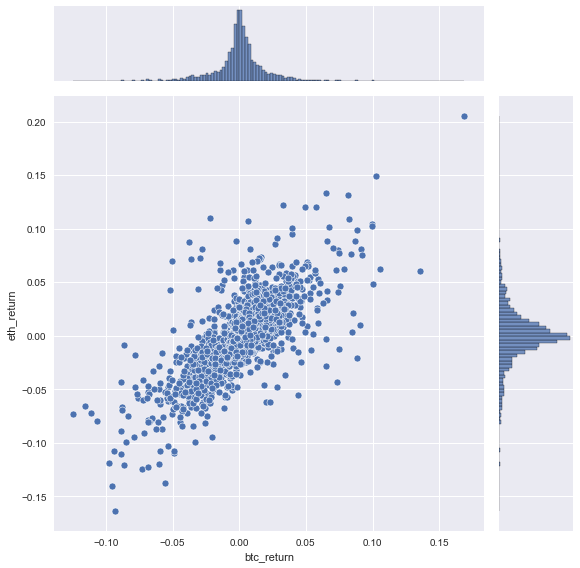

In [2]:
sns.jointplot(data=daily_returns, x='btc_return', y='eth_return', kind='scatter', height=8)
plt.show()

Here we see a scatter plot of the returns. There is definitely some dependence between the two, but we cannot discern a lot of details beyond that it *appears* like linear dependence. However, this is essentially a simple visualization of the joint PDF, so the scatter plot not only reflects the dependency structure, but also the marginal distributions. We can see histograms of the return distributions as well, and they do not look like they could be modeled with a Normal or student t distribution. This motivates the whole idea behind using pseudo observations, instead of trying to fit the return distributions to e.g. a Normal distribution or t distribution first. 

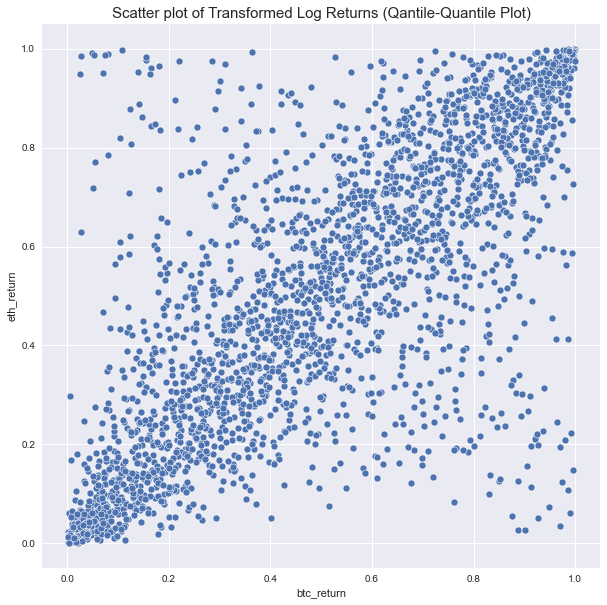

In [6]:
def make_uniform(data):
    '''
    peforms the probability integral transform
    '''
    n = len(data)
    x = rankdata(data, method='average')
    return x/(len(data)+1)

transformed_returns = daily_returns.apply(make_uniform, axis=0)
plt.subplots(figsize=(10,10))
sns.scatterplot(data=transformed_returns, x='btc_return', y='eth_return')
plt.title('Scatter plot of Transformed Log Returns (Qantile-Quantile Plot)', fontsize=(15))
plt.show()

The plot above is a scatter plot of the pseudo observations, the observations sampled from the empirical copula that links the marginal distributions of BTC and ETH to the joint distribution. It may not be entirely obvious at first, but this is in fact a Quantile-Quantile plot of the log returns.

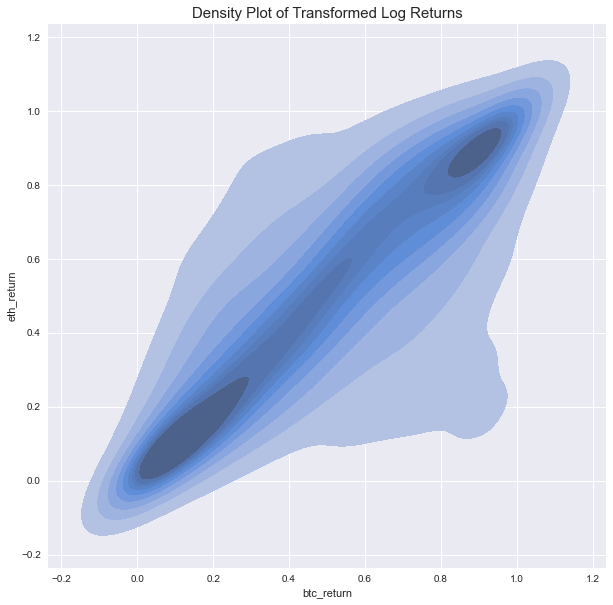

In [5]:
plt.subplots(figsize=(10,10))
sns.kdeplot(data=transformed_returns, x='btc_return', y='eth_return', fill=True)
plt.title('Density Plot of Transformed Log Returns', fontsize=15)
plt.show()

The density plot shows that the codependence between BTC and ETH returns is stronger in the tails. It is slightly stronger in the lower tail than in the upper tail. The shaded areas in the upper left and lower right part of the plot are the events we are going to trade on. These events represent times where one cryptocurrency did really well but the other one did not. This is the perfect time to place bets on reversion to the mean, i.e. short the crypto that did well and buy the crypto that did not do well. 

## Step 2

Let us start by getting an idea of what the objective function we want to optimize looks like. Note that, we are going to minimize this objective function, so in order to do Maximum Pseudo Likelihood estimation, we are going to minimize the negative pseudo (log) likelihood. 

In [9]:
''' This cell contains various functions needed'''

def quantile(u, df):
    x = t.ppf(u, df)
    return x

def multivariate_t_distribution(x,mu,Sigma,df,d=2):
    '''
    Multivariate t student density:
    output:
        the density of the given element
    input:
        x = parameter (d dimensional numpy array or scalar)
        mu = mean (d dimensional numpy array or scalar)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
        d: dimension
    '''
    Num = gamma(1. * (d+df)/2)
    Denom = ( gamma(1.*df/2) * pow(df*pi,1.*d/2) * pow(np.linalg.det(Sigma),1./2) * pow(1 + (1./df)*np.dot(np.dot((x - mu),np.linalg.inv(Sigma)), (x - mu)),1.* (d+df)/2))
    density = 1. * Num / Denom 
    return density

def univariate_t_ditribution(x, df):
    density = t.pdf(x=x, df=df, loc=0, scale=1)
    return density

def corr(data):
    P = data.corr().values
    return P

def bivariate_t_copula_density(row, df, P):
    '''
    Bivariate t copula density:
    output:
        the density of a given pair of u1 and u2
    input:
        row: a pair of u1 and u2, from the transformed log returns dataframe (numpy.array)
        df: degrees of freedom
        P: correlation matrix (numpy.array)
    '''
    
    u1 = row[0]
    u2 = row[1]
    x = quantile(row, df=df)
    mu = np.array([0,0])
    sigma = P
    num_density = multivariate_t_distribution(x=x, mu=mu, Sigma=sigma, df=df)
    denom_density = t.pdf(quantile(u1, df=df), df=df) * t.pdf(quantile(u2, df=df), df=df)
    copula_density = num_density/denom_density
    
    return np.log(copula_density)

def likelihood(data, df): 
    '''
    Compute the negative log of the cumulative product of the pairwise densities u1 and u2
    output:
        negative log likelihood
    input:
        data: probability integral transformed log returns (pandas.dataframe)
        df: degrees of freedom
    '''
    
    likelihoods = np.array([])
    P = data.corr().values
    
    for i in range(len(data)):
        row = data.iloc[i].values
        lik = bivariate_t_copula_density(row=row, df=df, P=P)
        likelihoods = np.append(likelihoods, lik)
        
    return np.cumsum(likelihoods)[-1]*-1

def optimize_me(df, data): 
    return likelihood(data=data, df=df)

def optimize(data):
    result = minimize(optimize_me,x0=2, args=(data,))
    print(result)
    return result.x[0]
    


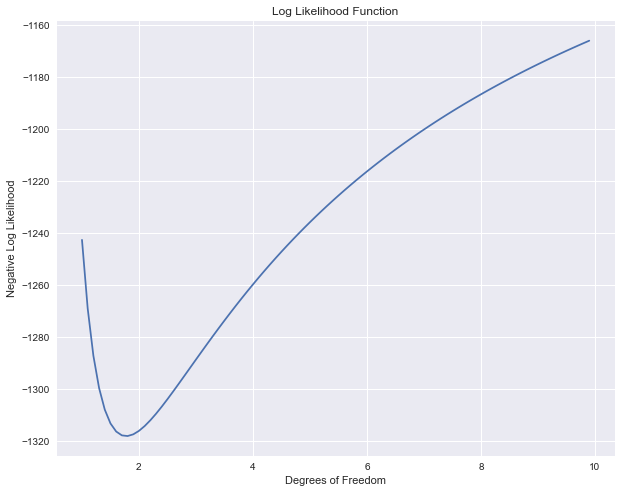

In [15]:
degrees_of_freedom = np.arange(1,10,0.1)
values = np.array([])

for i in degrees_of_freedom:
    val = likelihood(data=transformed_returns, df=i)
    values = np.append(values, val)
    
plt.figure(figsize=(10,8))
plt.plot(degrees_of_freedom, values)
plt.title('Log Likelihood Function')
plt.xlabel('Degrees of Freedom')
plt.ylabel('Negative Log Likelihood')
plt.show()

This is the "negative" log likelihood function. In order to maximize log likelihood, we minimize the negative. This is done because SciPy only has a minimizer. Note that the code above and below this cell takes a while to run. 

In [13]:
result = optimize(data=transformed_returns)

      fun: -1317.9729300914
 hess_inv: array([[0.00020038]])
      jac: array([7.62939453e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 118
      nit: 6
     njev: 53
   status: 2
  success: False
        x: array([1.77419693])


In [14]:
optimal_dof = result 

The hardest part is over, we have found the degrees of freedom that makes the copula best fit the training data. Now we use this parameter to compute the conditional probabilities.

## Step 3

In [15]:
def conditional_probability(data, dof):
    '''
    compute the probability of BTC having a "lower than current" return, conditional on current return on ETH.
    Adds these probabilities as a column to the probability integral transformed log returns
    input:
        data: transformed log returns (pandas.dataframe)
        dof: the degrees of freedom to use. Use optimize() to compute this paramter
        
    '''
    
    rho = data.corr().values[0,1]  
    data['conditional_prob'] = t.cdf((t.ppf(data['btc_return'], df=dof) - rho*t.ppf(data['eth_return'], df=dof)) / (np.sqrt((dof+(t.ppf(data['eth_return'], df=dof))**2)*(1-rho**2)/(dof+1))), df=dof+1)                
    
    return data

In [76]:
conditional_probability(data=transformed_returns, dof=optimal_dof)

,btc_return,eth_return,conditional_prob
date,,,
2017-09-01,0.766881,0.448553,0.917230
2017-09-02,0.062701,0.043408,0.453128
2017-09-03,0.501608,0.487138,0.521100
2017-09-04,0.046624,0.017685,0.648995
2017-09-05,0.803859,0.868167,0.475048
...,...,...,...
2019-05-10,0.811897,0.667203,0.865378
2019-05-11,0.990354,0.967846,0.969826
2019-05-12,0.157556,0.295820,0.116017


## Step 4
We've extracted the conditional probabilities implied by the copula we fit to the training data, but to make things a little more realistic, we are going to compute probabilities on out of sample log returns (the log returns not used for fitting the copula). 

In [77]:
out_of_sample_data.head()

,btc_return,eth_return
date,,
2019-05-15,0.027503,0.134410
2019-05-16,-0.040865,0.061270
2019-05-17,-0.069395,-0.080342
2019-05-18,-0.012537,-0.042088
2019-05-19,0.121738,0.110373


Like before, we need to turn our out of sample returns into pseudo observations, but in order to avoid look-ahead bias, we cannot feed the out of sample returns into its own empirical CDF. Instead, we are going to use a rolling window type approach: The length of the window is the same as the length of the testing sample, which contains $n$ pairs of observations. For the first set of observations in the testing data, we use the $n-1$ last observations of the training data, to construct the empirical CDF from which we can compute the first pair of pseudo observations. For the second pair of observations we in the testing data, we use the $n-2$ last observations of the training data, in addition to the returns of the previous period (which are the first observations in the testing data), in order to construct the empirical CDF. We continue this process until we reach the end of the testing data, such that for the last pair of observations in the testing data, we use the $n-1$ last observations in the testing dataset.

In [50]:
def make_uniform_out_of_sample(data):
    '''
    Performs the probability integral transform on the out-of-sample data in a way that avoids look-ahead bias.
    input:
        data: original price data (pandas.dataframe)
    output:
        a pandas.dataframe with the transformed returns
    '''
    
    data['btc_return'] = np.log(data['btcusd']) - np.log(data['btcusd'].shift(1))
    data['eth_return'] = np.log(data['ethusd']) - np.log(data['ethusd'].shift(1))
    data.dropna(inplace=True)
    data = data[['btc_return', 'eth_return']]
    idx = round(len(data)/2)
    out_sample = data[idx:].copy()
                
    result = pd.DataFrame({
        'btc_return': np.nan,
        'eth_return': np.nan
    }, index=out_sample.index)
    
    for i in range(len(result)):
        result.iloc[i] = [make_uniform(data['btc_return'][i:idx+i])[-1], make_uniform(data['eth_return'][i:idx+i])[-1]]
    return result

In [17]:
transformed_returns_out_of_sample = make_uniform_out_of_sample(data=data)

In [18]:
out_of_sample_data['conditional_prob'] = conditional_probability(data=transformed_returns_out_of_sample, dof=optimal_dof)['conditional_prob']

In [19]:
# 1 = long btc short eth
# -1 = opposite
ub = 0.90
lb = 0.1
out_of_sample_data['dummy'] = np.where(out_of_sample_data['conditional_prob'] >= ub, 1, np.where(out_of_sample_data['conditional_prob'] <= lb, -1, 0))
out_of_sample_data['position'] = 0

# Unpythonic loop to set our position at time t
pd.set_option('mode.chained_assignment', None)
for i in range(len(out_of_sample_data)):

    if (out_of_sample_data['dummy'][i] == 0 ):
        out_of_sample_data['position'][i] = out_of_sample_data['position'][i-1]

    elif (out_of_sample_data['dummy'][i] == 1):
        out_of_sample_data['position'][i] = 1

    elif (out_of_sample_data['dummy'][i] == -1):
        out_of_sample_data['position'][i] = -1

    else:
        print('Something else happened')

# Notice the .shift(-1), this is so that at the end of time t, when we have computed our position, we get the return of period t+1
out_of_sample_data['return'] = np.where(out_of_sample_data['position']<0, (-1*out_of_sample_data['btc_return'].shift(-1)+out_of_sample_data['eth_return'].shift(-1)), 
                                       (out_of_sample_data['btc_return'].shift(-1)-out_of_sample_data['eth_return'].shift(-1)))
out_of_sample_data['cumulative_return'] = np.cumsum([out_of_sample_data['return']])

# this is just for plotting-aesthetics
out_of_sample_data.reset_index(inplace=True)
out_of_sample_data.iloc[0] = ['2019-05-15', 0,0,0,0,0,0,0]
out_of_sample_data.set_index('date', inplace=True)
out_of_sample_data.index = pd.to_datetime(out_of_sample_data.index)

out_of_sample_data['buy_hold_btc'] = np.cumsum(out_of_sample_data['btc_return'])
out_of_sample_data['buy_hold_eth'] = np.cumsum(out_of_sample_data['eth_return'])




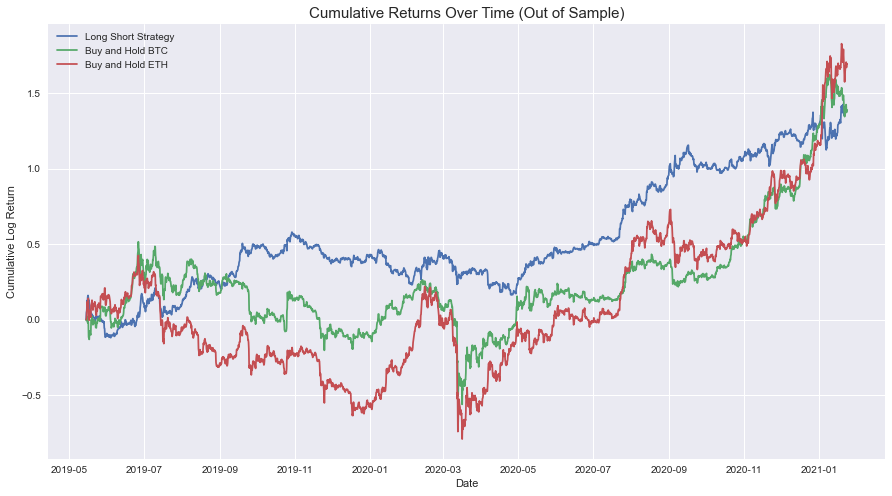

In [21]:
plt.subplots(figsize=(15,8))
plt.plot(out_of_sample_data.index, out_of_sample_data['cumulative_return'], label='Long Short Strategy')
plt.plot(out_of_sample_data.index, out_of_sample_data['buy_hold_btc'], label='Buy and Hold BTC')
plt.plot(out_of_sample_data.index, out_of_sample_data['buy_hold_eth'], label='Buy and Hold ETH')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.title('Cumulative Returns Over Time (Out of Sample)', fontsize=15)
plt.legend()
plt.show()

The strategy seems to have performed okay when BTC and ETH trade parallel but when a strong upwards trend started form around late 2020, the strategy shaves off all of its gains. Keep in mind that we never once re-fit the copula, so we used the correlation matrix $P$ with $\nu$ degrees of freedom from the training data (which ended in mid 2019) all the way into 2021. In a more realistic scenario, you would probably want to re-estimate those parameters after certain time or perhaps try a different copula or even mix several copulas. One interesting result not shown here, is that the strategy does not perform as well on daily data as it does on this six-hourly data. This looks promising, but what about turnover? How often does this strategy trade on the probabilities?

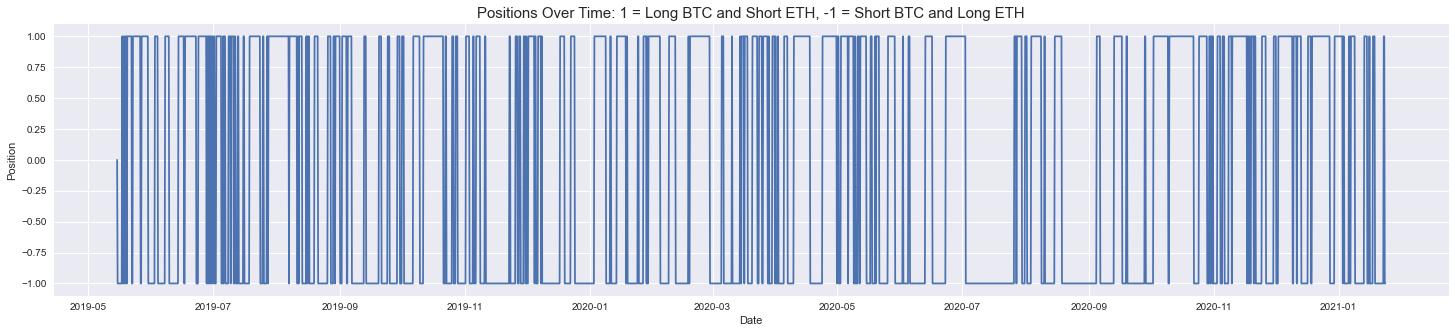

In [49]:
plt.subplots(figsize=(25,5))
plt.plot(out_of_sample_data.index, out_of_sample_data['position'])
plt.xlabel('Date')
plt.ylabel('Position')
plt.title('Positions Over Time: 1 = Long BTC and Short ETH, -1 = Short BTC and Long ETH', fontsize=15)
plt.show()

Turnover looks really high. One of the advantages with trading crypto is that fees are relatively lower compared to equities if you use a non-discount broker (in Europe, anyway) but it seems doubtful that this strategy can keep up with a buy-and-hold approach if we factor in commissions and slippage.

# References

Demarta, S., & McNeil, A. J. (2005). The t copula and related copulas. International statistical review, 73(1), 111-129.

Hofert, M., Kojadinovic, I., Mächler, M., & Yan, J. (2019). Elements of copula modeling with R. Springer.

Rad, H., Low, R. K. Y., & Faff, R. (2016). The profitability of pairs trading strategies: distance, cointegration and copula methods. Quantitative Finance, 16(10), 1541-1558.
